# 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn

In [ ]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [ ]:
# 데이터 경로
data_path = "/content/drive/MyDrive/모듈프로젝트4_team8/workspace/"

In [ ]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")


In [ ]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing


In [ ]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [ ]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [ ]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
train_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [ ]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True) 

In [ ]:
for index, data in enumerate(train_df["label"].unique()):
  print(index)
  print(data)

0
0
1
1
2
2


In [ ]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,0
1,v_CricketShot_g08_c02.avi,CricketShot,0
2,v_CricketShot_g08_c03.avi,CricketShot,0
3,v_CricketShot_g08_c04.avi,CricketShot,0
4,v_CricketShot_g08_c05.avi,CricketShot,0
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,2
352,v_TennisSwing_g25_c03.avi,TennisSwing,2
353,v_TennisSwing_g25_c04.avi,TennisSwing,2
354,v_TennisSwing_g25_c05.avi,TennisSwing,2


In [ ]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df = sklearn.utils.shuffle(train_df)

In [ ]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
232,v_Punch_g25_c01.avi,Punch,1
290,v_TennisSwing_g15_c04.avi,TennisSwing,2
174,v_Punch_g16_c03.avi,Punch,1
308,v_TennisSwing_g18_c01.avi,TennisSwing,2
3,v_CricketShot_g08_c04.avi,CricketShot,0
...,...,...,...
268,v_TennisSwing_g12_c03.avi,TennisSwing,2
196,v_Punch_g19_c04.avi,Punch,1
193,v_Punch_g19_c01.avi,Punch,1
33,v_CricketShot_g12_c06.avi,CricketShot,0


In [ ]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)


In [ ]:
# video 파일명 리턴
train_df["video_name"].loc[0]

'v_CricketShot_g08_c01.avi'

In [ ]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"train/"+train_df["video_name"].loc[0])

In [ ]:
# 비디오 파일 프레임 이미지 조회
video

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [ ]:
video.shape

(20, 224, 224, 3)

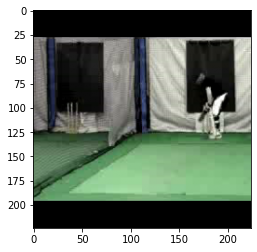

In [ ]:
# 첫번째 프레임 출력
plt.imshow(video[0]/255)

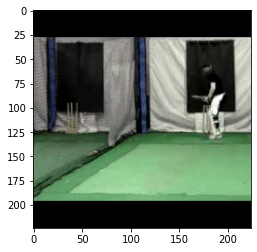

In [ ]:
# 10번째 프레임 출력
plt.imshow(video[10]/255)

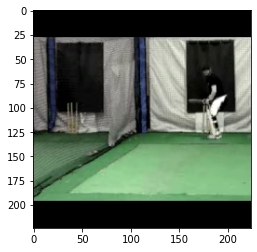

In [ ]:
# 19번째 프레임 조회
plt.imshow(video[19]/255)

In [ ]:
# 비디오 파일 종류 조회
train_df["label"].values

array([1, 2, 1, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0,
       2, 1, 0, 0, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 1, 0, 2,
       1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 0, 1, 0, 2, 2, 2, 2,
       2, 1, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 1, 0, 0, 2, 1, 2, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1,
       1, 2, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 1, 1,
       2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2,
       0, 2, 2, 1, 2, 1, 1, 0, 2, 2, 0, 1, 0, 1, 2, 2, 1, 0, 0, 0, 1, 1,
       2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 2, 0,
       1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 1, 1, 0, 1, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 1, 2, 0, 1,
       2, 1, 1, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 2, 2, 0, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2, 1, 0, 0, 1, 2,
       1, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1,

In [ ]:
# 비디오 파일의 종류를 2차원 배열로 변환
train_df["label"].values.reshape(-1,1)

array([[1],
       [2],
       [1],
       [2],
       [0],
       [0],
       [0],
       [2],
       [2],
       [0],
       [1],
       [1],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2],
       [1],
       [2],
       [1],
       [0],
       [2],
       [1],
       [0],
       [0],
       [1],
       [1],
       [2],
       [1],
       [2],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [2],
       [2],
       [0],
       [1],
       [0],
       [2],
       [1],
       [0],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [0],
       [1],
       [1],
       [1],
       [2],
       [0],
       [1],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [0],
       [0],
       [1],
       [2],
       [2],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [2],
       [1],
    

In [ ]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [ ]:
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path + "train/")

In [ ]:
# 전체 비디오 프레임을 이미지로 변환
X_train

array([[[[ 18.,  13.,  10.],
         [ 18.,  13.,  10.],
         [ 18.,  13.,  10.],
         ...,
         [ 56.,  14.,   0.],
         [ 86.,  36.,   7.],
         [110.,  60.,  29.]],

        [[ 18.,  13.,  10.],
         [ 18.,  13.,  10.],
         [ 18.,  13.,  10.],
         ...,
         [ 54.,  14.,   0.],
         [ 84.,  35.,   6.],
         [109.,  59.,  28.]],

        [[ 18.,  13.,  10.],
         [ 18.,  13.,  10.],
         [ 18.,  13.,  10.],
         ...,
         [ 51.,  13.,   0.],
         [ 79.,  32.,   7.],
         [103.,  55.,  28.]],

        ...,

        [[230., 245., 250.],
         [230., 246., 250.],
         [230., 247., 251.],
         ...,
         [108., 172., 251.],
         [114., 173., 247.],
         [115., 173., 247.]],

        [[230., 242., 239.],
         [231., 243., 240.],
         [231., 245., 242.],
         ...,
         [131., 181., 222.],
         [130., 175., 221.],
         [128., 173., 219.]],

        [[ 63.,  75.,  71.],
       

In [ ]:
X_train.shape

(7120, 224, 224, 3)

In [ ]:
#비디오 종류
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
y_train.shape

(7120, 3)

In [ ]:
X_train[0].shape

(224, 224, 3)

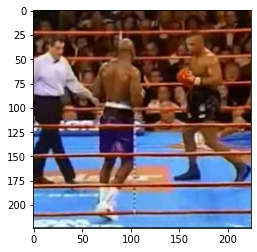

In [ ]:
# 0번째 비디오 프레임 이미지
plt.imshow(X_train[0]/255)

In [ ]:
# 0번째 프레임 이미지 종류
y_train[0]

array([0., 1., 0.], dtype=float32)

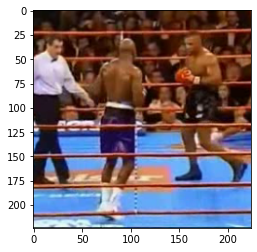

In [ ]:
# 1번째 비디오 프레임 이미지
plt.imshow(X_train[1]/255)

In [ ]:

# 1번째 프레임 이미지 종류
y_train[1]

array([0., 1., 0.], dtype=float32)

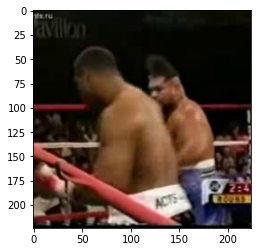

In [ ]:
# 1000 번째 프레임 이미지
plt.imshow(X_train[1000]/255)

In [ ]:
# 1000 번째 프레임 이미지 종류
y_train[1000]

array([0., 1., 0.], dtype=float32)

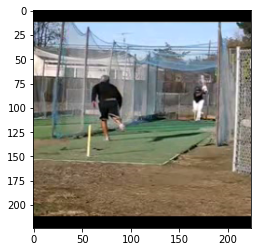

In [ ]:
# 4759 번째 프레임 이미지
plt.imshow(X_train[4759]/255)

In [ ]:
# 4759 번째 프레임 종류
y_train[4759]

array([1., 0., 0.], dtype=float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# ResNet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

In [ ]:
model = ResNet50(weights='imagenet')

x = model.output
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)

predictions = Dense(3, activation='softmax')(x)


model = Model(inputs=model.input, outputs=predictions)

model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

In [ ]:
model.compile(
                 optimizer=tf.keras.optimizers.Adam(1e-4)
                 ,loss='categorical_crossentropy'
                 ,metrics=['accuracy']
             )

In [ ]:
# 이미지를 증강하는 ImageGenerator 객체 생성
train_datagen = ImageDataGenerator(
	rotation_range=30, # 이미지 회전 각도
	zoom_range=0.15, # 이미지 확대 비율
	width_shift_range=0.2, # 이미지 가로 이동 비율
	height_shift_range=0.2, # 이미지 세로 이동 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전
	fill_mode="nearest", # 이미지를 회전 이동시 빈공간을 채우는 방식
    rescale=1/255 # 이미지에 1/255 를 곱해줌
	)

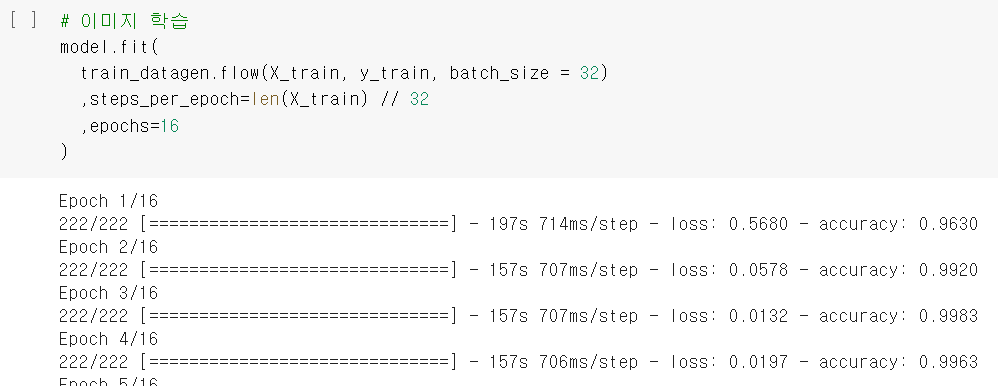

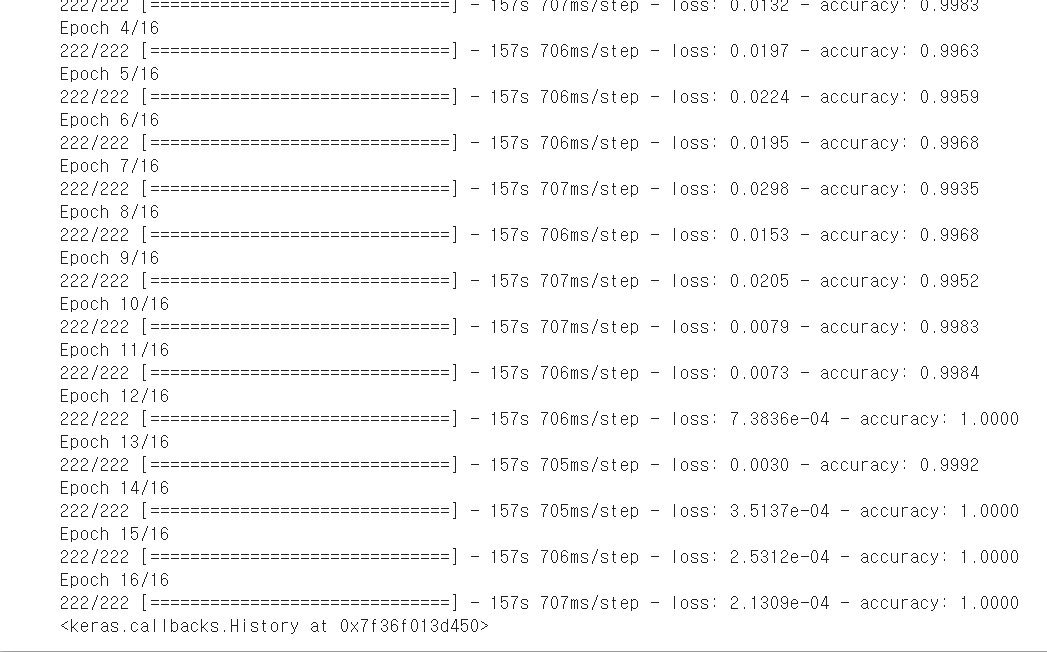

In [ ]:
# 이미지 학습
model.fit(
	train_datagen.flow(X_train, y_train, batch_size = 32)
	,steps_per_epoch=len(X_train) // 32
	,epochs=16
)

Epoch 1/16
222/222 [==============================] - 197s 714ms/step - loss: 0.5680 - accuracy: 0.9630
Epoch 2/16
222/222 [==============================] - 157s 707ms/step - loss: 0.0578 - accuracy: 0.9920
Epoch 3/16
222/222 [==============================] - 157s 707ms/step - loss: 0.0132 - accuracy: 0.9983
Epoch 4/16
222/222 [==============================] - 157s 706ms/step - loss: 0.0197 - accuracy: 0.9963
Epoch 5/16
222/222 [==============================] - 157s 706ms/step - loss: 0.0224 - accuracy: 0.9959
Epoch 6/16
222/222 [==============================] - 157s 706ms/step - loss: 0.0195 - accuracy: 0.9968
Epoch 7/16
222/222 [==============================] - 157s 707ms/step - loss: 0.0298 - accuracy: 0.9935
Epoch 8/16
222/222 [==============================] - 157s 706ms/step - loss: 0.0153 - accuracy: 0.9968
Epoch 9/16
222/222 [==============================] - 157s 707ms/step - loss: 0.0205 - accuracy: 0.9952
Epoch 10/16
222/222 [==============================] - 157s 707m

In [ ]:
model.save("/content/drive/MyDrive/모듈프로젝트4_team8/ResNet_train.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
